# Introduction

The dataset relates to revenue prediction on Google's online advertising platform sourced from the **Kaggle competition Machine Learning Battle - MATH2319**. The problem at hand is to predict a revenue-related metric for each website traffic record in the test data. The Dataset can be accessed by going to the link [Link to Dataset](https://www.kaggle.com/c/machine-learning-battle-mlmath2319/data).

# Data Description

This dataset contains real-world online advertising data where the target feature is a revenue-related metric and the descriptive features are various advertising metrics and characteristics. Each row represents a website traffic record that comes from a specific country, company, and device type combination. The dataset contains 30 days of training data and 5 days of test data. The training data contains about 215K records and the test data contains about 31K records.

## Data fields

The various data fields that are used as given below:

* **`companyId:`** - Company ID of record (categorical)
* **`countryId:`** - Country ID of record (categorical)
* **`deviceType:`** - Device type of record (categorical corresponding to desktop, mobile, tablet)
* **`day:`** -Day of record (integer between 1 (oldest) and 30 for train, 31 and 35 (most recent) for test)
* **`dow:`** - Day of week of the record (categorical)
* **`price1, price2, price3:`** - Price combination for the record set by the company (numeric)
* **`ad_area:`** - area of advertisement (normalized between 0 and 1)
* **`ad_ratio:`** - ratio of advertisement’s length to its width (normalized between 0 and 1)
* **`requests, impression, cpc, ctr, viewability:`** - Various metrics related to the record (numeric)
* **`ratio1, …, ratio5:`** - Ratio characteristics related to the record (each normalized between 0 and 1)
* **`y (target feature):`** - revenue-related metric (numeric)

The currency features are in US Dollars.

# Goals and Objectives

Our goal for this project is to to predict the y (target) for the test phases. We did a whole bunch of data descriptive analysis on this dataset. So we are not going to repeat this again here. We first load all the libraries required for this project.


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import dill
import math
import random

import altair as alt
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, RobustScaler, scale
from sklearn import feature_selection as fs

from catboost import Pool, CatBoostRegressor, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,LinearRegression,ElasticNet,Ridge

from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from scipy import stats

# Debug Flags

We set up some flags that can be used for debugging and testing and then this flag is set to false at the long run. Because the data is having 250k records for training we are restricting it to 100k records for most training. This ensure we can run most of it in an AWS Sagemaker instance with 16 cores and 200 GB EBS memory.

In [3]:
# setting flags
debug=False
if debug == True: 
    seed = 10 
    samples = 25000 # 25k records
else: 
    seed=np.random.randint(100000)
    samples = 100000 # 100k records
    
num_features = 10

# Load Files

We want to load the test and train records from the CSV into a pandas DF for use in various algorithm building.

In [6]:
raw_train_data = pd.read_csv(train_data_location,
                       dtype={'companyId':str,'countryId':str,'deviceType':str,'day':str,'dow':str,'price1':np.float64,
                              'price2':np.float64,'price3':np.float64,'ad_area':np.float64,'ad_ratio':np.float64,'requests':np.float64,'impression':np.float64,
                              'cpc':np.float64,'ctr':np.float64,'viewability':np.float64,'ratio1':np.float64,'ratio2':np.float64,'ratio3':np.float64,
                              'ratio4':np.float64,'ratio5':np.float64,'y':np.float64})
                             
raw_test_data = pd.read_csv(test_data_location,
                       dtype={'companyId':str,'countryId':str,'deviceType':str,'day':str,'dow':str,'price1':np.float64,
                              'price2':np.float64,'price3':np.float64,'ad_area':np.float64,'ad_ratio':np.float64,'requests':np.float64,'impression':np.float64,
                              'cpc':np.float64,'ctr':np.float64,'viewability':np.float64,'ratio1':np.float64,'ratio2':np.float64,'ratio3':np.float64,
                              'ratio4':np.float64,'ratio5':np.float64,'y':np.float64})

# Data Preprocessing


The dataset in hand is already preprocessed also we do not know a lot of features due to privacy related concerns hence we dont have much to go by. There are 5 categorical features - **companyId**, **countryId**, **deviceType**,**day**,**dow**. Depending on feature analysis and approach taken we may have to convert this into one-hot encoded features so we do that in this phase itself.

## One Hot Encoding

Once the CSV are loaded, we do our preprocessing. We notice that the complete train record has 163 country ids whereas the test data only has 138 countries and by removing the additional 25 countries we already reduce our feature set by 25 columns.

In [7]:
hot_train_data = raw_train_data.copy()
hot_test_data = raw_test_data.copy()

test_country = raw_test_data['countryId'].unique()

hot_train_data = hot_train_data[hot_train_data.countryId.isin(test_country)]
print(hot_train_data.shape)

cat_columns = ['companyId','countryId','deviceType','day','dow']

hot_train_data_y = hot_train_data['y']
hot_train_data_x = hot_train_data.drop('y', axis=1)

(213534, 21)


We now use One Hot encoding on the data set. We want a test to see all the countries in the test is present in the train as well. This is important since we are sampling and it is important to have same feature set on both.

We also want to check and see if there are any new categorical features in the test data that is not present in training. This will ensure our algorithms then dont run into any unforeseen issues.

In [8]:
hot_train_data_x = pd.get_dummies(hot_train_data_x, prefix_sep="__",columns=cat_columns)

cat_dummies = [col for col in hot_train_data_x 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

processed_columns = list(hot_train_data_x.columns[:])

# Remove additional columns
for col in hot_test_data.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        #print("Removing additional feature {}".format(col))
        hot_test_data.drop(col, axis=1, inplace=True)
        
for col in cat_dummies:
    if col not in hot_test_data.columns:
        #print("Adding missing feature {}".format(col))
        hot_test_data[col] = 0        
        
hot_test_data = hot_test_data[processed_columns]
#hot_train_data = hot_train_data_x.join(hot_train_data_y)
hot_train_data = hot_train_data_x
hot_train_data.shape

(213534, 200)

## Data Transformation

We know from our phase I analysis that a lot of features are very right skewed and so we want to try and scale this down. The best scaler for this purpose appears to be the Robust Scaler from SKLearn package. 

Robust Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). In our exercise we set the range to 10% and 90%. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.


In [9]:
robust_scaler = RobustScaler(quantile_range=(10.0, 90.0)).fit(hot_train_data)
trans_train_data = robust_scaler.transform(hot_train_data)
trans_test_data = robust_scaler.transform(hot_test_data)
print(trans_train_data.shape)
print(trans_test_data.shape)

(213534, 200)
(30910, 200)


In [10]:
processed_columns_with_y = processed_columns.copy()
processed_columns_with_y.append('y')
#trans_train_data_df = pd.DataFrame(trans_train_data,columns=processed_columns_with_y)
trans_train_data_df = pd.DataFrame(trans_train_data,columns=processed_columns)

# Feature Selection

Feature Selection is an important aspect of our analysis. This is because once encoded we haev 200 features and most of it appears to be sparse matrix. We can see that there are only 9 countries that have more than 5k records and 50 countries have less than 50 records in the training set. Most ML models perform well with reduced features since they are always reduce noise. There are several ways to do feature selection. In our exercise we try all of them.

## Feature Selection Using F-Score

This feature selection is the fastest to execute since this is a univariate linear regression test for the data.

In [11]:
fs_fit_fscore = fs.SelectKBest(fs.f_regression, k=num_features)
fs_fit_fscore.fit_transform(trans_train_data_df.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed))
fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:num_features]
fs_indices_fscore

best_features_fscore = trans_train_data_df.columns[fs_indices_fscore].values
best_features_fscore

feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([4595.60900096, 4254.23482272, 3105.27036396, 2809.00167163,
       2574.12633092, 2552.40699589, 1835.25265163, 1655.67060763,
       1453.0248496 , 1087.29016909])

We plot the best features for this model in a graph and pick out the best features

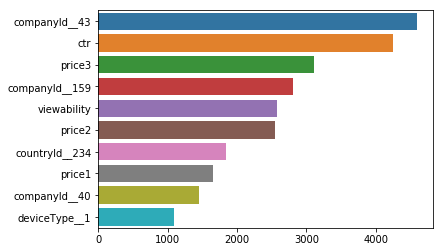

In [12]:
ax = sns.barplot(x=feature_importances_fscore, y=best_features_fscore)

## Feature using RFI

By far one of the most famous feature selection methods is to do a Random Forest algorithm based feature selection. This type of feature selection is called Embedded method as it has both qualities of wrapper and filter methods. Some of the reasons why this is prominet is that it is fast, accurate, do not overfit and can be easily interpreted.

In [13]:
samples = 100000
model_rfi =  RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model_rfi.fit(trans_train_data_df, hot_train_data_y)


RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

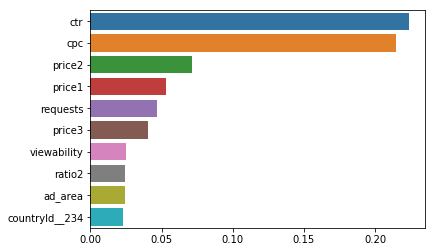

In [14]:
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]
best_features_rfi = trans_train_data_df.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
ax = sns.barplot(x=feature_importances_rfi, y=best_features_rfi)

We see from here that the model fitting showing the top 10 features - we can see that while this overlaps slightly with the F-SCore selection there are still some differences.

## Feature Selection Using SPSA

This feature selection is based on a recent study by Vural Aksakalli and Milad Malekipirbazari as published in the https://arxiv.org/pdf/1508.07630.pdf website. Their paper indicate this feature selection to be better thab RF method. So we try that as well here. There is an additional library ( SpFtSel ) which can be downloaded from the https://github.com/vaksakalli/spsaml_py.


In [15]:
from SpFtSel import SpFtSel

wrapper =  RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

sp_engine = SpFtSel(trans_train_data_df.sample(samples, random_state = seed).values, 
                    hot_train_data_y.sample(samples, random_state = seed), 
                    wrapper, 'neg_mean_squared_error')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
np.random.seed(seed)
sp_output = sp_engine.run(10,stratified_cv=False).results

spFtSel-INFO: Algorithm run mode: regular
spFtSel-INFO: Wrapper: RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
spFtSel-INFO: Scoring metric: neg_mean_squared_error
spFtSel-INFO: Number of features: 200
spFtSel-INFO: Number of observations: 100000
spFtSel-INFO: iter: 0, value: -1.927, std: 0.054, num. features: 10, best value: -1.927
spFtSel-INFO: iter: 5, value: -1.882, std: 0.106, num. features: 10, best value: -1.878
spFtSel-INFO: iter: 10, value: -1.813, std: 0.066, num. features: 10, best value: -1.813
spFtSel-INFO: iter: 15, value: -1.84, std: 0.071, num. features: 10, be

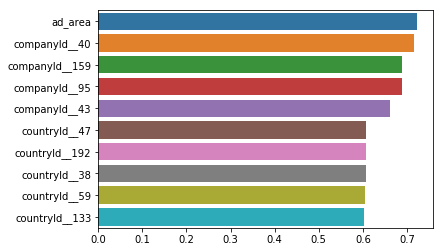

In [17]:
fs_indices_spsa = sp_output.get('features')
fs_indices_spsa
best_features_spsa = trans_train_data_df.columns[fs_indices_spsa].values
best_features_spsa
feature_importances_spsa = sp_output.get('importance')
feature_importances_spsa
ax = sns.barplot(x=feature_importances_spsa, y=best_features_spsa)

We see here that the SPSA method shows an entirely new set of features that are mostly the one hot encoded features.

## Features using Mutual Importance

The last try is by doing the mutual importance feature selection. This is the slowest mechanism and hence the sample size is set to 25k.Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

In [18]:
samples = 25000 # resetting sample because of how long it takes to run
fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_regression, k=num_features)
fs_fit_mutual_info.fit_transform(trans_train_data_df.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed))


array([[-8.84955752e-03, -5.38922156e-02, -1.11556800e-01, ...,
        -9.66297431e-03,  3.98129813e+00,  5.67046450e-01],
       [-8.84955752e-03, -5.38922156e-02, -1.11556800e-01, ...,
        -3.74734857e-02, -1.87018702e-02, -3.64154251e-01],
       [ 0.00000000e+00,  1.19760479e-01,  1.04139862e-01, ...,
         3.33443318e+00, -1.21012101e-02, -3.35451358e-01],
       ...,
       [ 6.19469027e-02,  3.59281437e-02,  0.00000000e+00, ...,
         1.76526043e-01,  7.70077008e-03, -1.32340053e-01],
       [ 4.24778761e-01,  4.01197605e-01,  4.60796186e-01, ...,
         1.03464530e-01,  2.12321232e-01,  3.68755478e-01],
       [-8.84955752e-03, -5.38922156e-02, -1.11556800e-01, ...,
        -2.82818760e-03,  3.64796480e+00,  2.74868536e-01]])

In [19]:
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]
best_features_mutual_info = trans_train_data_df.columns[fs_indices_mutual_info].values
mutal_info_scores = fs_fit_mutual_info.scores_[::-1][0:num_features]
feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
feature_importances_mutual_info

array([0.19591737, 0.18599883, 0.1328392 , 0.09214925, 0.08320799,
       0.06855907, 0.06631189, 0.06073871, 0.05392177, 0.05167132])

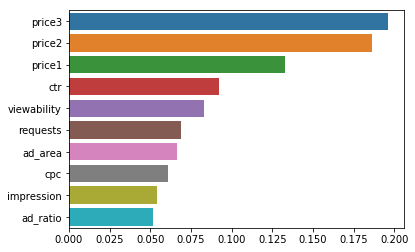

In [20]:
ax = sns.barplot(x=feature_importances_mutual_info, y=best_features_mutual_info)

This shows the best features and again we see that they are quite different to the other ones.

# Feature Selection

Based on the 4 feature selection techniques a set of features are selected. 

* The categorical features - `day` and `dow` are dropped since they are not coming up in any of the techniques.
* The ratio features - `ratio1` , `ratio2` , `ratio3` , `ratio4` , `ratio5` are all dropped since they also dont appear in any of the models.
* The `countryId` is the feature that has the most categorical values and needs the most manual data wrangling. For e.g. the top 10 countries which has more than 5k samples in the training data were automatically selected. Additionally all countries that had a large Std Deviation in the target was chosen for analysis if they had more than 1k records. The other countries were set to a value of 'others'
* No other features were dropped 

## Feature Selection

Here we drop the `day` and `dow` features

In [58]:
raw_train_data = raw_train_data.drop(['day', 'dow'], axis=1)
print(raw_train_data.shape)

test_country = raw_test_data['countryId'].unique()
raw_train_data = raw_train_data[raw_train_data.countryId.isin(test_country)]
print(raw_train_data.shape)

(214128, 19)
(213534, 19)


## Feature Engineering

Here we create a lookup of selected countries and everything else is set to 'other'

In [59]:
cnty_list = {"59" : "59" , "77" : "77" , "234" : "234" , "56" : "56" , "13" : "13" , "12" : "12" , "57" : "57" , "38" : "38"}
raw_train_data['countryId'] = raw_train_data['countryId'].map(cnty_list).fillna("other")
raw_test_data['countryId'] = raw_test_data['countryId'].map(cnty_list).fillna("other")

print(raw_train_data['countryId'].value_counts())
print(raw_test_data['countryId'].value_counts())

other    132600
234       21507
56        12152
57        11435
38        10822
77        10779
13         6121
12         5793
59         2325
Name: countryId, dtype: int64
other    17996
234       3607
56        2013
57        1773
38        1689
77        1679
13         967
12         839
59         347
Name: countryId, dtype: int64


We also pickle the data so that we can reuse it later.

In [61]:
raw_train_data.to_pickle("./raw_train_data.pkl")
raw_test_data.to_pickle("./raw_test_data.pkl")

# Model Selection

We try different model Selection Techniques, run Grid Search on all of them and then identify the best parameters for this model. In our project we try 3 differnet algorithms.

* Cat Boost
* Random Forest
* Ridge and Lasso Regression

## CatBoost Modelling

One of the advantages of CatBoost is that it works very well with models that feature categorical variables. It does not need the data to be one hot encoded as well and is blazing fast. Here we restrict the data to just the selected features.

In [22]:
raw_training_data = pd.read_pickle("./raw_train_data.pkl")
raw_test_data = pd.read_pickle("./raw_test_data.pkl")

In [24]:
train_data_x = raw_training_data[['companyId','countryId','deviceType','price1','price2','price3','ad_area','ad_ratio','requests',
                                       'impression','cpc','ctr','viewability']]
train_data_y = raw_training_data['y']
test_data_x = raw_test_data[['companyId','countryId','deviceType','price1','price2','price3','ad_area','ad_ratio','requests',
                                       'impression','cpc','ctr','viewability']]


### Defining debugging and normal parameters

In this section we define the various grid search parameters that we want to test the data against.

In [26]:
model = CatBoostRegressor(loss_function='RMSE')
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'depth'         : [6,8],
                  'learning_rate' : [0.01,0.05],
                  'iterations'    : [10,30]
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.001,0.01,0.05,0.1,0.5,1],
                  'iterations'    : [10,30,40,50,75,100]
                 }

### Hyper Parameter Tuning

Based on the list of parameters that we want to test we run a complete grid search.

In [12]:
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = cv_method, n_jobs=-2)
grid.fit(train_data_x,train_data_y, cat_features=[0,1,2])    

0:	learn: 1.6227459	total: 332ms	remaining: 2.99s
1:	learn: 1.6157683	total: 684ms	remaining: 2.74s
2:	learn: 1.6086711	total: 1.02s	remaining: 2.39s
3:	learn: 1.6018697	total: 1.39s	remaining: 2.08s
4:	learn: 1.5950584	total: 1.73s	remaining: 1.73s
5:	learn: 1.5882682	total: 2.07s	remaining: 1.38s
6:	learn: 1.5816255	total: 2.43s	remaining: 1.04s
7:	learn: 1.5750209	total: 2.72s	remaining: 680ms
8:	learn: 1.5685312	total: 3s	remaining: 333ms
9:	learn: 1.5620946	total: 3.28s	remaining: 0us


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000001F9448696A0>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F944869630>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [10, 30],
                         'learning_rate': [0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Results

We print the best parameter based on the sample that we tested.

In [13]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 1.562448724892328

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 10, 'learning_rate': 0.01}



## Random Forest Model

As a second approach we try a Random Forest Model. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True. 

### One Hot Encoding

RF algorithm requires data to be one hot encoded. We do that on the reduced dataset.


In [4]:
hot_train_data = raw_training_data.copy()
hot_test_data = raw_test_data.copy()

cat_columns = ['companyId','countryId','deviceType']

hot_train_data_y = hot_train_data['y']
hot_train_data_x = hot_train_data.drop('y', axis=1)

In [5]:
hot_train_data_x = pd.get_dummies(hot_train_data_x, prefix_sep="__",columns=cat_columns)

cat_dummies = [col for col in hot_train_data_x 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

processed_columns = list(hot_train_data_x.columns[:])

# Remove additional columns
for col in hot_test_data.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        #print("Removing additional feature {}".format(col))
        hot_test_data.drop(col, axis=1, inplace=True)
        
for col in cat_dummies:
    if col not in hot_test_data.columns:
        #print("Adding missing feature {}".format(col))
        hot_test_data[col] = 0        
        
hot_test_data = hot_test_data[processed_columns]
#hot_train_data = hot_train_data_x.join(hot_train_data_y)
hot_train_data = hot_train_data_x
hot_train_data.shape

(213534, 29)

### Defining debugging and normal parameters

We define various ranges for the model that we want to test here.

In [6]:
model = RandomForestRegressor()
    
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'n_estimators'  : [10,20],
                  'bootstrap'     : ['True','False'],
                  'max_depth'     : [10,30],
                  'min_samples_leaf' : [2,5,7]
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'n_estimators'  : [20,30,40,50,100,500,1000],
                  'bootstrap'     : ['True','False'],
                  'max_depth'     : [5,10,20],
                  'min_samples_leaf' : [2,5,7]
                 }

### Hyper Parameter Tuning

In this section we run the various grid searches to find the best model.

In [9]:
grid = GridSearchCV(estimator=model, param_grid = parameters, 
                    scoring = 'neg_mean_squared_error'  ,cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(hot_train_data.sample(samples, random_state = seed),hot_train_data_y.sample(samples, random_state = seed))

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x00000186B5C9B7F0>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_le...
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
           

### Results

We display the best parameter that we found after hyper parameter search.

In [10]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

 The best score across ALL searched params:
 -0.9363509903165219

 The best parameters across ALL searched params:
 {'bootstrap': 'False', 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 1000}



## Regression Techniques

The last technique that we want to try is the Regression techniques. In our module we try the Lasso and Ridge regression. Since we already cut down the features to 29 in total we do not need to do Eastic-Net Regression. 

PS : I actually tried and it made no difference :)

### Data Transformation

The first step in doing Regression is to scale the data because the co-efficients all have to be in same range. as discussed earlier we did the robust scaling to ensure outliers are captured in our model without too many issues.

In [6]:
robust_scaler = RobustScaler(quantile_range=(10.0, 90.0)).fit(hot_train_data)
trans_train_data = robust_scaler.transform(hot_train_data)
trans_test_data = robust_scaler.transform(hot_test_data)
print(trans_train_data.shape)
print(trans_test_data.shape)

(213534, 29)
(30910, 29)


### Ridge Regression

Ridge Regression is a form of Regression that adds a penalty to the regressor if the co-efficient value is too large. In our case we see that most of the regressors are in the same range. However we still try Ridge.

#### Defining debugging and normal parameters

In [15]:
ridgeReg = Ridge()
    
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'alpha'  : [0.005,0.01,0.05],
                  'normalize'     : ['True','False']
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'alpha'  : [0.0005,0.001,0.01,0.02,0.05,0.08,0.1,2,5],
                  'normalize'     : ['True','False']
                 }

#### Hyper Parameter Tuning

In Ridge Regression there are not many parameters that we can tweak so we jsut tune for alpha values.

In [16]:
grid = GridSearchCV(estimator=ridgeReg, param_grid = parameters, 
                    scoring = 'neg_mean_squared_error'  ,cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(pd.DataFrame(trans_train_data).sample(samples, random_state = seed),hot_train_data_y.sample(samples, random_state = seed))

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000002050476A9E8>,
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.02, 0.05, 0.08, 0.1,
                                   2, 5],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

#### Results & Plotting Co-Efficients

We plot the best Ridge parameters for our model.

In [17]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize='True', random_state=None, solver='auto', tol=0.001)

 The best score across ALL searched params:
 -1.56788743905607

 The best parameters across ALL searched params:
 {'alpha': 0.0005, 'normalize': 'True'}



In [18]:
ridgeReg = Ridge(alpha=0.0005, normalize=True)
ridgeReg.fit(trans_train_data,hot_train_data_y)

Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

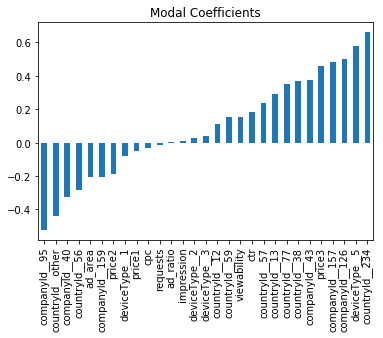

In [19]:
coeff= pd.Series(data=ridgeReg.coef_,index=hot_train_data_x.columns).sort_values()
coeff.plot(kind='bar', title='Modal Coefficients')

### Lasso Regression

Lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

#### Defining debugging and normal parameters

Again we do not have a large number of points to tune on and hence we try various combinations of alpha.

In [20]:
lassoReg = Lasso()
    
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'alpha'  : [0.0005,0.005,0.01,0.05],
                  'normalize'     : ['True','False']
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'alpha'  : [0.0005,0.001,0.01,0.02,0.05,0.08,0.1,2,5],
                  'normalize'     : ['True','False']
                 }

#### Hyper Parameter Tuning

We do a grid search on all the variables and observe the performance on the best model.

In [21]:
grid = GridSearchCV(estimator= lassoReg   , param_grid = parameters, 
                    scoring = 'neg_mean_squared_error'  ,cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(pd.DataFrame(trans_train_data).sample(samples, random_state = seed),hot_train_data_y.sample(samples, random_state = seed))

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000002050482EBE0>,
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.02, 0.05, 0.08, 0.1,
                                   2, 5],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

#### Results & Plotting

We want to then model on the latest co-efficients from the Lasso Regression. Plotting it shows that there are only 3 parameters that are of any significance. These are `countryId_other` , `companyId_43` and  `ctr`. All of the others are set to zero.

In [22]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize='True', positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

 The best score across ALL searched params:
 -1.7079127746476468

 The best parameters across ALL searched params:
 {'alpha': 0.0005, 'normalize': 'True'}



In [23]:
lassoReg = Lasso(alpha= 0.0005, normalize = 'True')
lassoReg.fit(trans_train_data,hot_train_data_y)


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize='True', positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

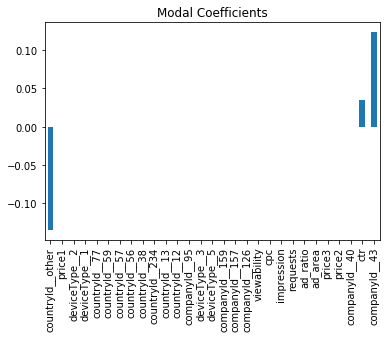

In [25]:
coeff= pd.Series(data=lassoReg.coef_,index=hot_train_data_x.columns).sort_values()
coeff.plot(kind='bar', title='Modal Coefficients')

# Model Comparison

Now that we have the best parameters for all 3 models - we want to try and compare them. To do this first we do a cross valdiation score for all of this models.

## CatBoost CV

Here we try and do a CV on the CatBoost Model

In [12]:
cat_boost_model = CatBoostRegressor(iterations=10, 
                          depth=6, 
                          learning_rate=0.01)

cat_boost_scores = cross_val_score(cat_boost_model, hot_train_data_x.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed), 
                            cv = 10, scoring='neg_mean_squared_error', n_jobs=-2)
cat_boost_scores

array([-2.22584768, -2.62116975, -2.52702749, -2.70033064, -2.09665427,
       -2.43745152, -2.16684991, -2.35708358, -2.87138926, -2.30551288])

## RF CV

Next we compute the CV scores for the RF model.

In [7]:
rf_model = RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

rf_scores = cross_val_score(rf_model, hot_train_data_x.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed), 
                            cv = 10, scoring='neg_mean_squared_error', n_jobs=-2)
rf_scores

array([-0.75940265, -0.9548364 , -0.8674509 , -1.08265095, -0.85727927,
       -0.97729199, -0.77146472, -0.76227208, -1.56733113, -0.7077677 ])

In [11]:
from scipy import stats

print(stats.ttest_rel(cat_boost_scores, rf_scores).pvalue)

1.6939731423054425e-10


## Ridge CV

We then compute the CV scores for the Ridge Regression

In [7]:
ridge_model = Ridge(alpha=0.0005, normalize=True)


ridge_scores = cross_val_score(ridge_model, hot_train_data_x.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed), 
                            cv = 10, scoring='neg_mean_squared_error', n_jobs=-2)
ridge_scores

array([-1.38013412, -1.69026608, -1.65523106, -1.83278287, -1.31555049,
       -1.6510014 , -1.37612882, -1.4637951 , -2.12481187, -1.43495523])

## Lasso CV

Lastly we compute the cross validation scores for Lasso.

In [9]:
lasso_model = Lasso(alpha= 0.0005, normalize = 'True')


lasso_scores = cross_val_score(lasso_model, hot_train_data_x.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed), 
                            cv = 10, scoring='neg_mean_squared_error', n_jobs=-2)
lasso_scores

array([-1.45750762, -1.76846444, -1.74269905, -1.89778579, -1.35866591,
       -1.70849022, -1.43997016, -1.54375114, -2.15620681, -1.51730313])

## T-Test Comparison

We see from all the CV means that the best possible model is the RF model. The order of CV results are :

* RF Model
* Ridge Regression Model
* Lasso CV Model
* Cat Boost Model

But we want to statistically prove that so We do 2 wat T-Test between all the models. The Null Hypothesis for the T-Test is that there is no significant difference between the 2 models that are being compared.

First we do a 2 way test between Cat Boost and RF Models

In [35]:
print(stats.ttest_rel(cat_boost_scores, rf_scores).pvalue)

1.711047663521452e-10


We can see that the RF model is significantly different from the Cat Boost Model. This we reject the null hypothesis that the RF and CatBoost model are giving same results. 

Next we try comparing the RF to the Ridge model.

In [36]:
print(stats.ttest_rel(ridge_scores, rf_scores).pvalue)

7.193233360809907e-09


We can see that the RF model is significantly different from the Ridge Model. This we reject the null hypothesis that the RF and Ridge model are giving same results. 

Next we try comparing the RF to the Lasso model.

In [37]:
print(stats.ttest_rel(lasso_scores, rf_scores).pvalue)

1.0154922545399423e-08


We can see that the RF model is significantly different from the Lasso Model. This we reject the null hypothesis that the RF and Lasso model are giving same results. 

We thus conclude that the best model is the **Random Forest** model.

# Final Model

Based on all of the above modelling techniques we have picked the best model as the RF model. We do one more round of model build like the below.

In [5]:
rf_model = RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Once the model is finalised, we then fit the entire training data to the model.

In [6]:
rf_model.fit(hot_train_data_x,hot_train_data_y)

RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# Score Model

Once we have the final model we then try and score the test data. 

In [7]:
# make the prediction using the resulting model
preds = rf_model.predict(hot_test_data)

# Create Submission File

In [9]:
sub_csv = pd.DataFrame({'case_id': range(1,hot_test_data.shape[0]+1),
                       'y' :preds})
sub_csv.to_csv("./sub_csv.csv",index=False)

# Limitations

We had several limitations with this dataset and modelling.

* A little bit more background info could be really handy in a lot instances. For e.g. we dropped all the ratio features after featuer selection because they did not come up as prominent. Also all the Feature Selection Techniques show differnet featuers and so a combination of them was taken for this exercise. Maybe a SME could have advised us better on the best set of featuers

* The size of the train dataset was 215k records. Ideally we would have liked to run this as a pipeline but because we did not have enough resources (tried even in AWS with a 16 core Sagemaker instance) but it still takes time. Hence Sampling approach was taken.

* We have not tried Tensor Flow or NN techniques here. Maybe they yield a better response compared to the traditional models.

# References

* Yenice, Z., Adhikari, N., Wong, Y., Aksakalli, V., Gumus, A. and Abbasi, B. (2019). SPSA-FSR: Simultaneous Perturbation Stochastic Approximation for Feature Selection and Ranking. [online] arXiv.org. Available at: https://arxiv.org/abs/1804.05589 [Accessed 2 Jun. 2019].

* Scikit-learn.org. (2019). sklearn.feature_selection.mutual_info_regression — scikit-learn 0.21.2 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html [Accessed 2 Jun. 2019].

* JAIN, S. (2019). A comprehensive beginners guide for Linear, Ridge and Lasso Regression. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/ [Accessed 2 Jun. 2019].

* Towards Data Science. (2019). Feature Selection Using Random forest. [online] Available at: https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f [Accessed 2 Jun. 2019].

* Catboost.ai. (2019). CatBoostRegressor. [online] Available at: https://catboost.ai/docs/concepts/python-reference_catboostregressor.html [Accessed 2 Jun. 2019].

